<a href="https://colab.research.google.com/github/there-exist/thereexist_/blob/master/2019_11_28_Green's_function_for_power_law_process(numpy%2C_scipy_%3E_mpmath).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import library

#import numpy as np
'''
numpy를 import 하면, complex number를 계산하지 못하는 문제가 생겼다. (inverse laplace transfom을 할 때 complex number를 쓰기 때문에)

이를 mpmath로 모두 전환을 하는 경우, 문제가 해결이 되었다.
'''
import matplotlib.pyplot as plt
import mpmath as mp
from sympy import *
from sympy.abc import t, T, a, u

init_printing()
mp.dps = 15; mp.pretty = True

(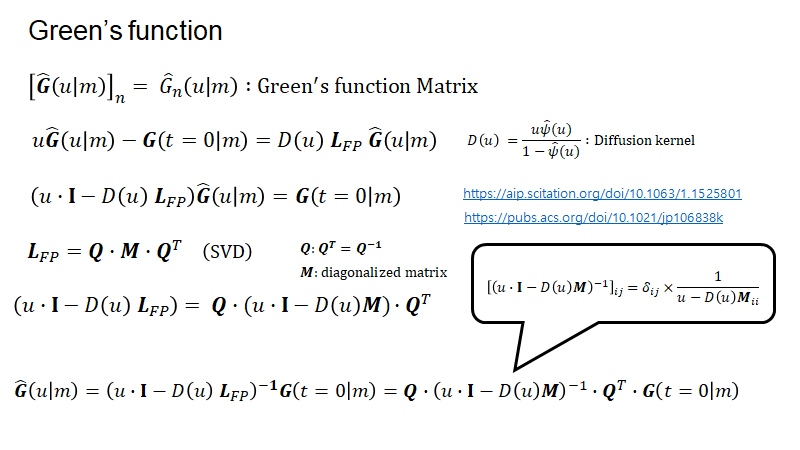))

대략적인 알고리즘의 형태는 다음과 같다.

Matrix $Q$와 $M$은 이미 논문에 그 값이 주어졌기에, 그것을 활용하면 된다.
(https://aip.scitation.org/doi/10.1063/1.1525801, https://pubs.acs.org/doi/10.1021/jp106838k)

**1. 각 Matrix 정의하기**

In [0]:
'''
Q라고 이름을 기입했더니 Question을 의미하는 용어와 혼동을 빚어 이후에 문제가 생겼다.(total_tensor를 만들 때)
그래서 이름을 Qu로 바꿨다.

때로는 이름을 어떻게 기입하는지가 중요한 모양이다.
'''
'''
Qu(N)

Size : (N+1 x N+1)

'''

def Qu(N):
  Qu = mp.matrix(N+1,N+1)

  for i in range(0,N+1):
    for k in range(0,N+1):
        
      if k == 0:

        Qu[i,k] = mp.sqrt(1/(N+1))*mp.cos((i+0.5)*k*mp.pi/(N+1))

      else:

        Qu[i,k] = mp.sqrt(2/(N+1))*mp.cos((i+0.5)*k*mp.pi/(N+1))

  return Qu

In [0]:
'''
M(N)

Size : (N+1 x N+1)

'''
def M(N):

  M = mp.matrix(N+1,N+1)

  for i in range(0,N+1):
    for k in range(0,N+1):

      if i == k:

        M[i,k] = -4 * (mp.sin(k*mp.pi / (2*(N+1))))**2

  
  return M

In [0]:
'''
round 처리를 하지 않으면, 0에 근사한 값이어도 0으로 안나오고, E-17 등의 order로 나타난다.

'''
def L_FP(N):
  return (Qu(N)*(M(N)*Qu(N).T))


$\hat\psi(u)$ 의 형태는 여기에서 바꾸면 된다. 

$\psi(t) = 1 / (1+t/t_d)^{1+\alpha}$

In [0]:
def hat_psi(td, a, u):  
    
    result = a*mp.exp(td*u)*(td*u)**a* mp.gammainc(-a,td*u,mp.inf)
    
    return result


In [9]:
print(hat_psi(1, 0.5, 10))

0.0439133870697233


In [0]:
def D(td, a, u):  
  psi = hat_psi(td, a, u)
  return u*psi / (1-psi)

이제 필요한 것들을 모두 구했기에,

$G(t=0,m)$ 앞에 붙는 Matrix operator를 만들어 주면 된다.

이 전체 matrix ( $Q (uI - D(u)M)^{-1}$ ) 을 Operator matrix로 선언했다.

In [0]:
def operator_matrix(N, u, td, a):

  qu = Qu(N)
  m = M(N)
  d = D(td, a, u)

  Diagonalized_Matrix = mp.matrix(N+1,N+1)
  
  for i in range(0,N+1):
    Diagonalized_Matrix[i,i] = (u - d*m[i,i])**-1
  
  result = qu * (Diagonalized_Matrix * qu.T)

  return result


$G(t=0,m)$ matrix는 $(N+1,1)$ 꼴의 형태를 갖는다.

$[G(t=0,m)]_{n,m} = \delta_{nm}$ 이다.


In [0]:
def G_0(m, N):

  result = mp.matrix(N+1,1)

  result[m,0] = 1

  return result

$\hat G(u,m)$를 구할 모든 준비를 마쳤다. 이제 이를 구현해보면 된다.

In [0]:
def Green_matrix (m, N, u, td, a):

  A = operator_matrix(N, u, td, a)
  x = G_0(m, N)

  result = A*x

  return result

In [0]:
'''
n = measured position
m = initial position
N = upper boundary
u = laplace space
k = related with hat_psi value. This variable can be replaced by another value
    depending on the jumping process
'''

def Green_function(n, m, N, u, td, a):

  return Green_matrix (m, N, u, td, a)[n,0]
  

In [15]:
print(type(Green_function))

<class 'function'>


우선은 Graph를 그리기 위한 모든 준비를 마쳤다. 

이를 G_graph function으로 define했다.

In [0]:
def G_graph(u_initial, u_final, slicing_number, n, m, N, td, a):
  
  U = mp.linspace(u_initial,u_final,slicing_number)

  Ga = []

  for i in U:

    G = Green_function(n, m, N, i, td, a)
    Ga.append(G)
 

  return U, Ga

n = 5


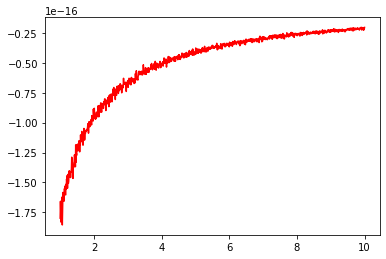

In [0]:
%%time
for i in range(1,11):
  U, Ga = G_graph(u_initial = 1, u_final = 10, slicing_number = 1000, n = 5*i, m = 50, N = 100, td = 1, a = 0.5)

  plt.plot(U, Ga, 'r')
  
  print('n =', 5*i)
  plt.show()

이제 numerical하게 inverse laplace transformation을 하는 방법을 구하면, 

Green's function을 time domain에서 구현할 수 있게 된다.

In [0]:
g = lambda u: Green_function(45, 50, 100, u, 1, 0.5)

## Green_function(n, m, N, u, td, a)

Time = mp.linspace(1,100,1000)

G = []

for i in Time:
    result = invertlaplace(g,i, method= 'talbot')
    
    G.append(result)
    
plt.plot(Time,G,'r-')
    

In [0]:
hat_psi(1, 0.5, 11.84)

In [0]:
print(int(2.5))

2


In [0]:
print (mp.linspace(1,10,10))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
